In [1]:
!pip install streamlit plotly pandas yfinance ta pytz


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 599.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.8 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e627d24241b5b081a5551487b6d06aa7d1af37b285dcbdb82f4615fee05eb145
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
!pip install pyngrok

In [24]:
%%writefile stock.py
import yfinance as yf
import pandas as pd
import streamlit as st
import plotly.graph_objects as go

# Function to fetch stock data
def get_stock_data(ticker, period="1mo", interval="1d"):
    stock = yf.Ticker(ticker)
    real_time_data = stock.history(period=period, interval=interval)

    if not real_time_data.empty:
        last_price = real_time_data['Close'].iloc[-1]  # Get last closing price
        opening_price = real_time_data['Open'].iloc[0]  # Get first opening price
        return real_time_data, last_price, opening_price
    else:
        return None, None, None

# Streamlit UI
st.set_page_config(page_title="Stock Market Dashboard", layout="wide")
st.title("📈 Real-Time Stock Market Dashboard")

# User input for stock ticker
ticker = st.text_input("Enter Stock Ticker Symbol (e.g., AAPL, TSLA, GOOG):", "AAPL")

if st.button("Get Stock Data"):
    data, last_price, opening_price = get_stock_data(ticker)

    if data is not None:
        st.markdown(f"### **Stock Data for {ticker}**")
        col1, col2 = st.columns(2)

        with col1:
            st.metric(label="📌 Last Price", value=f"${last_price:.2f}")
        with col2:
            st.metric(label="📌 Opening Price", value=f"${opening_price:.2f}")

        # Line Chart
        st.subheader("📊 Stock Price Trend")
        fig_line = go.Figure()
        fig_line.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Close Price', line=dict(color='blue')))
        fig_line.update_layout(title=f"Stock Price Trend for {ticker}", xaxis_title="Date", yaxis_title="Price")
        st.plotly_chart(fig_line, use_container_width=True)

        # Candlestick Chart
        st.subheader("🕯️ Candlestick Chart")
        fig_candle = go.Figure(data=[go.Candlestick(
            x=data.index,
            open=data['Open'],
            high=data['High'],
            low=data['Low'],
            close=data['Close'],
            name="Candlestick"
        )])
        fig_candle.update_layout(title=f"Candlestick Chart for {ticker}", xaxis_title="Date", yaxis_title="Price")
        st.plotly_chart(fig_candle, use_container_width=True)

        # Show Raw Data
        with st.expander("📜 View Raw Data"):
            st.dataframe(data)

    else:
        st.error("Stock data could not be retrieved. Please check the ticker symbol.")



Overwriting stock.py


# **Stock.py is current data with candlestick graph**

In [28]:
!streamlit run stock.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.215.247:8501

⠼⠴your url is: https://lucky-worlds-taste.loca.lt
  Stopping...
^C


In [8]:
%%writefile tech.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# Load Data (User should upload CSV)
st.title("Stock Market Technical Analysis")
uploaded_file = st.file_uploader("Upload a CSV file with 'Close' prices", type=["csv"])

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file, index_col=0, parse_dates=True)
    st.write("Data Preview:", df.head())

    # Trend Analysis
    def trend(x):
        if -0.5 < x <= 0.5: return 'Slight or No change'
        elif 0.5 < x <= 1: return 'Slight Positive'
        elif -1 < x <= -0.5: return 'Slight Negative'
        elif 1 < x <= 3: return 'Positive'
        elif -3 < x <= -1: return 'Negative'
        elif 3 < x <= 7: return 'Among top gainers'
        elif -7 < x <= -3: return 'Among top losers'
        elif x > 7: return 'Bull run'
        else: return 'Bear drop'

    df['Trend'] = df['Close'].pct_change().apply(lambda x: trend(x))
    st.subheader("Trend Analysis")
    fig, ax = plt.subplots()
    df['Trend'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    ax.set_ylabel('')
    st.pyplot(fig)

    # Moving Averages
    st.subheader("Simple & Exponential Moving Averages")
    df['50_SMA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_SMA'] = df['Close'].rolling(window=200, min_periods=1).mean()
    df['50_EMA'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['200_EMA'] = df['Close'].ewm(span=200, adjust=False).mean()

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df['Close'], label='Close Price', color='black')
    ax.plot(df.index, df['50_SMA'], label='50-day SMA', color='blue')
    ax.plot(df.index, df['200_SMA'], label='200-day SMA', color='green')
    ax.plot(df.index, df['50_EMA'], label='50-day EMA', linestyle='dashed', color='blue')
    ax.plot(df.index, df['200_EMA'], label='200-day EMA', linestyle='dashed', color='green')
    ax.legend()
    st.pyplot(fig)

    # RSI
    st.subheader("Relative Strength Index (RSI)")
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df['RSI'], label='RSI', color='blue')
    ax.axhline(30, linestyle='--', color='red')
    ax.axhline(70, linestyle='--', color='green')
    ax.legend()
    st.pyplot(fig)

    # Bollinger Bands
    st.subheader("Bollinger Bands")
    indicator_bb = BollingerBands(df['Close'], window=20, window_dev=2)
    df['BB_Middle'] = indicator_bb.bollinger_mavg()
    df['BB_Upper'] = indicator_bb.bollinger_hband()
    df['BB_Lower'] = indicator_bb.bollinger_lband()

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.index, df['Close'], label='Close Price', color='black')
    ax.plot(df.index, df['BB_Middle'], label='Middle Band', color='blue')
    ax.plot(df.index, df['BB_Upper'], label='Upper Band', color='green')
    ax.plot(df.index, df['BB_Lower'], label='Lower Band', color='red')
    ax.fill_between(df.index, df['BB_Lower'], df['BB_Upper'], color='gray', alpha=0.3)
    ax.legend()
    st.pyplot(fig)


Overwriting tech.py


Tech.py is based on csv file technical analysis

In [11]:
!streamlit run techy.py & npx localtunnel --port 8501



⠙⠹
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.215.247:8501

⠸⠼⠴⠦your url is: https://cyan-eels-march.loca.lt
  Stopping...
^C


In [10]:
%%writefile techy.py
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# Function to fetch stock data
def get_stock_data(ticker, period='1y'):
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    return df

# Function to calculate trends
def trend(x):
    if x > -0.5 and x <= 0.5:
        return 'Slight or No change'
    elif x > 0.5 and x <= 1:
        return 'Slight Positive'
    elif x > -1 and x <= -0.5:
        return 'Slight Negative'
    elif x > 1 and x <= 3:
        return 'Positive'
    elif x > -3 and x <= -1:
        return 'Negative'
    elif x > 3 and x <= 7:
        return 'Among top gainers'
    elif x > -7 and x <= -3:
        return 'Among top losers'
    elif x > 7:
        return 'Bull run'
    elif x <= -7:
        return 'Bear drop'

# Streamlit App
st.title("Stock Market Technical Analysis")
ticker = st.text_input("Enter Stock Ticker (e.g., AAPL, TSLA, MSFT)", "AAPL")
period = st.selectbox("Select Time Period", ['1mo', '3mo', '6mo', '1y', '2y', '5y'], index=3)

if st.button("Analyze"):
    df = get_stock_data(ticker, period)
    df['Day_Perc_Change'] = df['Close'].pct_change() * 100
    df.dropna(inplace=True)
    df['Trend'] = df['Day_Perc_Change'].apply(lambda x: trend(x))

    # Plot Trends
    st.subheader("Market Trend Analysis")
    fig, ax = plt.subplots()
    df['Trend'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
    st.pyplot(fig)

    # Moving Averages
    st.subheader("Moving Averages")
    df['50_SMA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_SMA'] = df['Close'].rolling(window=200, min_periods=1).mean()
    fig, ax = plt.subplots()
    df['Close'].plot(ax=ax, color='k', label='Close Price')
    df['50_SMA'].plot(ax=ax, color='b', label='50-day SMA')
    df['200_SMA'].plot(ax=ax, color='g', label='200-day SMA')
    ax.legend()
    st.pyplot(fig)

    # RSI Indicator
    st.subheader("Relative Strength Index (RSI)")
    rsi = RSIIndicator(df['Close'], window=14)
    df['RSI'] = rsi.rsi()
    fig, ax = plt.subplots()
    ax.plot(df.index, df['RSI'], label='RSI', color='blue')
    ax.axhline(70, linestyle='--', color='red')
    ax.axhline(30, linestyle='--', color='green')
    ax.legend()
    st.pyplot(fig)

    # Bollinger Bands
    st.subheader("Bollinger Bands")
    bb = BollingerBands(df['Close'], window=20, window_dev=2)
    df['BB_Middle'] = bb.bollinger_mavg()
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Close'], label='Close Price', color='k')
    ax.plot(df.index, df['BB_Upper'], label='Upper Band', color='r')
    ax.plot(df.index, df['BB_Lower'], label='Lower Band', color='g')
    ax.fill_between(df.index, df['BB_Lower'], df['BB_Upper'], alpha=0.1)
    ax.legend()
    st.pyplot(fig)

    st.write("Data Preview:")
    st.dataframe(df.tail())


Writing techy.py


tech.py is technical analysis without parameters

In [14]:
%%writefile mcad.py
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD

# Function to fetch stock data
def get_stock_data(ticker, period='1y'):
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    return df

# Function to calculate buy and sell signals using MACD
def macd_signals(df):
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['Signal_Line'] = macd.macd_signal()
    df['Buy_Signal'] = (df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line'].shift(1))
    df['Sell_Signal'] = (df['MACD'] < df['Signal_Line']) & (df['MACD'].shift(1) >= df['Signal_Line'].shift(1))
    return df

# Streamlit App
st.title("Stock Market Technical Analysis")
ticker = st.text_input("Enter Stock Ticker (e.g., AAPL, TSLA, MSFT)", "AAPL")
period = st.selectbox("Select Time Period", ['1mo', '3mo', '6mo', '1y', '2y', '5y'], index=3)

if st.button("Analyze"):
    df = get_stock_data(ticker, period)
    df = macd_signals(df)

    # Plot Stock Price with Buy/Sell Signals
    st.subheader("Stock Price with Buy/Sell Signals")
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Close'], label='Close Price', color='black')
    ax.scatter(df.index[df['Buy_Signal']], df['Close'][df['Buy_Signal']], marker='^', color='green', label='Buy Signal', alpha=1)
    ax.scatter(df.index[df['Sell_Signal']], df['Close'][df['Sell_Signal']], marker='v', color='red', label='Sell Signal', alpha=1)
    ax.legend()
    st.pyplot(fig)

    # Show Data Preview
    st.write("Data Preview:")
    st.dataframe(df.tail())


Writing mcad.py


In [15]:
!streamlit run mcad.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.215.247:8501

⠴your url is: https://old-birds-cough.loca.lt
  Stopping...
^C


MCAD (Moving average) with buy and sell signal

In [16]:
%%writefile technicalanalysis.py
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD

# Function to fetch stock data
def get_stock_data(ticker, period='1y'):
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    return df

# Function to calculate trends
def trend(x):
    if x > -0.5 and x <= 0.5:
        return 'Slight or No change'
    elif x > 0.5 and x <= 1:
        return 'Slight Positive'
    elif x > -1 and x <= -0.5:
        return 'Slight Negative'
    elif x > 1 and x <= 3:
        return 'Positive'
    elif x > -3 and x <= -1:
        return 'Negative'
    elif x > 3 and x <= 7:
        return 'Among top gainers'
    elif x > -7 and x <= -3:
        return 'Among top losers'
    elif x > 7:
        return 'Bull run'
    elif x <= -7:
        return 'Bear drop'

# Function to calculate RSI buy and sell signals
def rsi_signals(df):
    rsi = RSIIndicator(df['Close'], window=14)
    df['RSI'] = rsi.rsi()
    df['Buy_Signal_RSI'] = df['RSI'] < 40
    df['Sell_Signal_RSI'] = df['RSI'] > 70
    return df

# Function to calculate Bollinger Bands buy and sell signals
def bollinger_signals(df):
    bb = BollingerBands(df['Close'], window=20, window_dev=2)
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    df['Buy_Signal_BB'] = df['Close'] < df['BB_Lower']
    df['Sell_Signal_BB'] = df['Close'] > df['BB_Upper']
    return df

# Function to calculate MACD buy and sell signals
def macd_signals(df):
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['Buy_Signal_MACD'] = df['MACD'] > df['MACD_Signal']
    df['Sell_Signal_MACD'] = df['MACD'] < df['MACD_Signal']
    return df

# Streamlit App
st.title("Stock Market Technical Analysis")
ticker = st.text_input("Enter Stock Ticker (e.g., AAPL, TSLA, MSFT)", "AAPL")
period = st.selectbox("Select Time Period", ['1mo', '3mo', '6mo', '1y', '2y', '5y'], index=3)

if st.button("Analyze"):
    df = get_stock_data(ticker, period)
    df['Day_Perc_Change'] = df['Close'].pct_change() * 100
    df.dropna(inplace=True)
    df['Trend'] = df['Day_Perc_Change'].apply(lambda x: trend(x))
    df = rsi_signals(df)
    df = bollinger_signals(df)
    df = macd_signals(df)

    # Plot Market Trends
    st.subheader("Market Trend Analysis")
    fig, ax = plt.subplots()
    df['Trend'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
    st.pyplot(fig)

    # Plot RSI with Buy/Sell Signals
    st.subheader("RSI Indicator with Buy/Sell Signals")
    fig, ax = plt.subplots()
    ax.plot(df.index, df['RSI'], label='RSI', color='blue')
    ax.axhline(70, linestyle='--', color='red', label='Overbought')
    ax.axhline(30, linestyle='--', color='green', label='Oversold')
    ax.scatter(df.index[df['Buy_Signal_RSI']], df['RSI'][df['Buy_Signal_RSI']], marker='^', color='green', label='Buy Signal', alpha=1)
    ax.scatter(df.index[df['Sell_Signal_RSI']], df['RSI'][df['Sell_Signal_RSI']], marker='v', color='red', label='Sell Signal', alpha=1)
    ax.legend()
    st.pyplot(fig)

    # Plot Bollinger Bands with Buy/Sell Signals
    st.subheader("Bollinger Bands with Buy/Sell Signals")
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Close'], label='Close Price', color='black')
    ax.plot(df.index, df['BB_Upper'], label='Upper Band', color='red')
    ax.plot(df.index, df['BB_Lower'], label='Lower Band', color='green')
    ax.fill_between(df.index, df['BB_Lower'], df['BB_Upper'], alpha=0.1)
    ax.scatter(df.index[df['Buy_Signal_BB']], df['Close'][df['Buy_Signal_BB']], marker='^', color='green', label='Buy Signal', alpha=1)
    ax.scatter(df.index[df['Sell_Signal_BB']], df['Close'][df['Sell_Signal_BB']], marker='v', color='red', label='Sell Signal', alpha=1)
    ax.legend()
    st.pyplot(fig)

    # Plot MACD with Buy/Sell Signals
    st.subheader("MACD Indicator with Buy/Sell Signals")
    fig, ax = plt.subplots()
    ax.plot(df.index, df['MACD'], label='MACD', color='blue')
    ax.plot(df.index, df['MACD_Signal'], label='Signal Line', color='red')
    ax.scatter(df.index[df['Buy_Signal_MACD']], df['MACD'][df['Buy_Signal_MACD']], marker='^', color='green', label='Buy Signal', alpha=1)
    ax.scatter(df.index[df['Sell_Signal_MACD']], df['MACD'][df['Sell_Signal_MACD']], marker='v', color='red', label='Sell Signal', alpha=1)
    ax.legend()
    st.pyplot(fig)

    # Moving Averages
    st.subheader("Moving Averages")
    df['50_SMA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_SMA'] = df['Close'].rolling(window=200, min_periods=1).mean()
    fig, ax = plt.subplots()
    df['Close'].plot(ax=ax, color='k', label='Close Price')
    df['50_SMA'].plot(ax=ax, color='b', label='50-day SMA')
    df['200_SMA'].plot(ax=ax, color='g', label='200-day SMA')
    ax.legend()
    st.pyplot(fig)

    st.write("Data Preview:")
    st.dataframe(df.tail())


Writing technicalanalysis.py


In [17]:
!streamlit run technicalanalysis.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴⠦
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.215.247:8501

⠧⠇your url is: https://early-bats-join.loca.lt
  Stopping...
^C


Technicalanalysis.py is with technical analysis but not accurate output

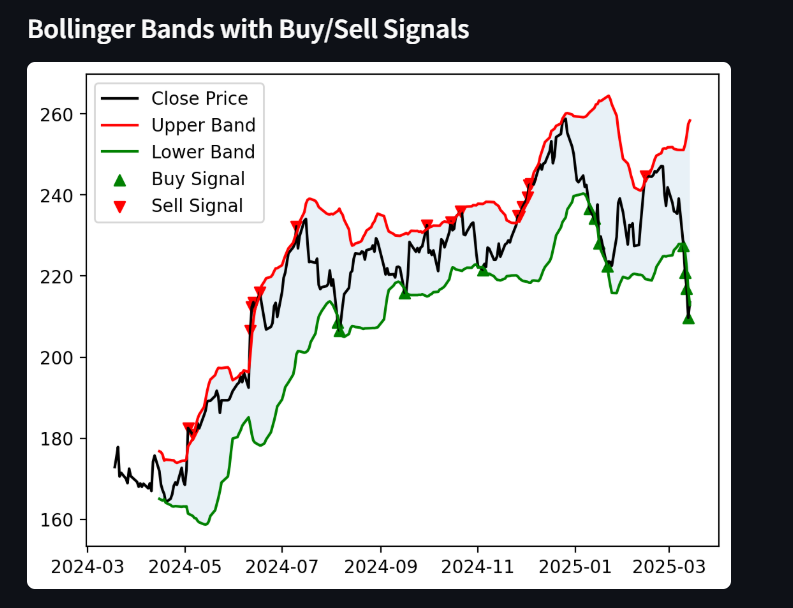

In [18]:
%%writefile bmcad.py
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD

# Function to fetch stock data
def get_stock_data(ticker, period='1y'):
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)
    return df

# Function to calculate buy and sell signals using MACD
def macd_signals(df):
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['Signal_Line'] = macd.macd_signal()
    df['Buy_Signal_MACD'] = (df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line'].shift(1))
    df['Sell_Signal_MACD'] = (df['MACD'] < df['Signal_Line']) & (df['MACD'].shift(1) >= df['Signal_Line'].shift(1))
    return df

# Function to calculate buy and sell signals using Bollinger Bands
def bollinger_signals(df):
    indicator_bb = BollingerBands(df['Close'])
    df['BB_High'] = indicator_bb.bollinger_hband()
    df['BB_Low'] = indicator_bb.bollinger_lband()
    df['Buy_Signal_BB'] = df['Close'] < df['BB_Low']
    df['Sell_Signal_BB'] = df['Close'] > df['BB_High']
    return df

# Streamlit App
st.title("Stock Market Technical Analysis")
ticker = st.text_input("Enter Stock Ticker (e.g., AAPL, TSLA, MSFT)", "AAPL")
period = st.selectbox("Select Time Period", ['1mo', '3mo', '6mo', '1y', '2y', '5y'], index=3)

if st.button("Analyze"):
    df = get_stock_data(ticker, period)
    df = macd_signals(df)
    df = bollinger_signals(df)

    # Plot Stock Price with MACD Buy/Sell Signals
    st.subheader("Stock Price with MACD Buy/Sell Signals")
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Close'], label='Close Price', color='black')
    ax.scatter(df.index[df['Buy_Signal_MACD']], df['Close'][df['Buy_Signal_MACD']], marker='^', color='green', label='Buy Signal (MACD)', alpha=1)
    ax.scatter(df.index[df['Sell_Signal_MACD']], df['Close'][df['Sell_Signal_MACD']], marker='v', color='red', label='Sell Signal (MACD)', alpha=1)
    ax.legend()
    st.pyplot(fig)

    # Plot Stock Price with Bollinger Bands and Buy/Sell Signals
    st.subheader("Stock Price with Bollinger Bands Buy/Sell Signals")
    fig, ax = plt.subplots()
    ax.plot(df.index, df['Close'], label='Close Price', color='black')
    ax.plot(df.index, df['BB_High'], label='Upper Bollinger Band', linestyle='dashed', color='blue')
    ax.plot(df.index, df['BB_Low'], label='Lower Bollinger Band', linestyle='dashed', color='blue')
    ax.scatter(df.index[df['Buy_Signal_BB']], df['Close'][df['Buy_Signal_BB']], marker='^', color='green', label='Buy Signal (BB)', alpha=1)
    ax.scatter(df.index[df['Sell_Signal_BB']], df['Close'][df['Sell_Signal_BB']], marker='v', color='red', label='Sell Signal (BB)', alpha=1)
    ax.legend()
    st.pyplot(fig)

    # Show Data Preview
    st.write("Data Preview:")
    st.dataframe(df.tail())


Writing bmcad.py


In [19]:
!streamlit run bmcad.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.215.247:8501

⠼⠴your url is: https://cruel-stars-obey.loca.lt
  Stopping...
^C


# **bmcad.py include Bollinger Bands Buy/Sell Signals and MCAD**


In [37]:
%%writefile stcokfinal.py
import streamlit as st
from datetime import date, datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD

# Configure page
st.set_page_config(
    page_title="Stock Analysis & Forecast App",
    page_icon="📈",
    layout="wide"
)

# App title and description
st.title('📈 Stock Analysis & Forecast App')
st.markdown("""
This app provides comprehensive stock analysis using technical indicators and forecasts future prices using Facebook's Prophet model.
""")

# Define available stock options
stocks = {
    "Google": "GOOGL",
    "Apple": "AAPL",
    "Microsoft": "MSFT",
    "Tesla": "TSLA",
    "Tata Motors": "TATAMOTORS.NS"
}

def fetch_data_from_yfinance(ticker, period='5y'):
    """Fetch stock data using yfinance"""
    try:
        # Get data for the specified period
        end_date = datetime.now()

        if period == '5y' or period == '1825d':
            start_date = end_date - timedelta(days=1825)
        else:
            # For technical analysis periods
            df = yf.download(ticker, period=period)
            return df

        # Download data for forecast
        df = yf.download(ticker, start=start_date, end=end_date)

        if not df.empty and len(df) > 30:
            return df
        return None
    except Exception as e:
        st.error(f"Error fetching data from Yahoo Finance: {str(e)}")
        return None

def get_sample_data(ticker):
    """Generate sample stock data for demonstration"""
    seed_value = sum(ord(c) for c in ticker)
    np.random.seed(seed_value)

    end_date = datetime.now()
    start_date = end_date - timedelta(days=1825)
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')

    # Set initial price based on ticker
    start_price = {
        'AAPL': 150,
        'GOOGL': 2800,
        'MSFT': 300,
        'TSLA': 800
    }.get(ticker, 100)

    # Generate price data
    daily_returns = np.random.normal(0.0005, 0.02, len(date_range))
    price_series = start_price * (1 + daily_returns).cumprod()

    # Create DataFrame
    df = pd.DataFrame(index=date_range)
    df['Close'] = price_series
    df['Open'] = df['Close'].shift(1) * (1 + np.random.normal(0, 0.005, len(df)))
    df['High'] = df[['Open', 'Close']].max(axis=1) * (1 + abs(np.random.normal(0, 0.003, len(df))))
    df['Low'] = df[['Open', 'Close']].min(axis=1) * (1 - abs(np.random.normal(0, 0.003, len(df))))
    df['Adj Close'] = df['Close']
    df['Volume'] = np.random.randint(100000, 10000000, len(df))

    return df.fillna(method='bfill')

def prepare_dataframe(df):
    """Prepare dataframe for Prophet model"""
    df = df.reset_index()
    result_df = pd.DataFrame()
    result_df['ds'] = df['Date']
    result_df['y'] = df['Close']
    return result_df

@st.cache_data(show_spinner=False)
def fetch_stock_data(stock_ticker, period='5y'):
    """Fetch stock data with fallback to sample data"""
    with st.spinner(f"Fetching data for {stock_ticker}..."):
        df = fetch_data_from_yfinance(stock_ticker, period)
        if df is not None and not df.empty and len(df) > 30:
            st.success(f"Successfully loaded data for {stock_ticker}")
            if period == '5y' or period == '1825d':
                return prepare_dataframe(df), df
            return df

        st.warning(f"Using sample data for {stock_ticker}")
        sample_data = get_sample_data(stock_ticker)
        if period == '5y' or period == '1825d':
            return prepare_dataframe(sample_data), sample_data
        return sample_data

# Technical Analysis Functions
def trend(x):
    if x > -0.5 and x <= 0.5:
        return 'Slight or No change'
    elif x > 0.5 and x <= 1:
        return 'Slight Positive'
    elif x > -1 and x <= -0.5:
        return 'Slight Negative'
    elif x > 1 and x <= 3:
        return 'Positive'
    elif x > -3 and x <= -1:
        return 'Negative'
    elif x > 3 and x <= 7:
        return 'Among top gainers'
    elif x > -7 and x <= -3:
        return 'Among top losers'
    elif x > 7:
        return 'Bull run'
    elif x <= -7:
        return 'Bear drop'

def rsi_signals(df):
    rsi = RSIIndicator(df['Close'], window=14)
    df['RSI'] = rsi.rsi()
    df['Buy_Signal_RSI'] = df['RSI'] < 40
    df['Sell_Signal_RSI'] = df['RSI'] > 70
    return df

def bollinger_signals(df):
    bb = BollingerBands(df['Close'], window=20, window_dev=2)
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    df['Buy_Signal_BB'] = df['Close'] < df['BB_Lower']
    df['Sell_Signal_BB'] = df['Close'] > df['BB_Upper']
    return df

def macd_signals(df):
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['Buy_Signal_MACD'] = df['MACD'] > df['MACD_Signal']
    df['Sell_Signal_MACD'] = df['MACD'] < df['MACD_Signal']
    return df

def perform_technical_analysis(df):
    """Calculate all technical indicators and signals"""
    df['Day_Perc_Change'] = df['Close'].pct_change() * 100
    df.dropna(inplace=True)
    df['Trend'] = df['Day_Perc_Change'].apply(lambda x: trend(x))
    df = rsi_signals(df)
    df = bollinger_signals(df)
    df = macd_signals(df)

    # Add moving averages
    df['50_SMA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_SMA'] = df['Close'].rolling(window=200, min_periods=1).mean()
    return df

def display_technical_analysis(df, ticker):
    """Display technical analysis charts and data"""
    st.header(f"Technical Analysis for {ticker}")

    # Market Trend Analysis
    st.subheader("Market Trend Analysis")
    col1, col2 = st.columns(2)
    with col1:
        fig, ax = plt.subplots(figsize=(8, 6))
        df['Trend'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax, colors=plt.cm.Paired.colors)
        plt.title('Distribution of Price Movements')
        st.pyplot(fig)

    with col2:
        st.markdown("### Trend Interpretation")
        st.write("""
        This pie chart shows the distribution of daily price movements categorized by trend strength.
        - **Bull run/Bear drop**: Extreme price movements (>7%)
        - **Top gainers/losers**: Strong movements (3-7%)
        - **Positive/Negative**: Moderate movements (1-3%)
        - **Slight changes**: Minor movements (0.5-1%)
        - **No change**: Minimal price movement (<0.5%)
        """)

    # RSI with Buy/Sell Signals
    st.subheader("RSI Indicator with Buy/Sell Signals")
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['RSI'], label='RSI', color='blue')
    ax.axhline(70, linestyle='--', color='red', label='Overbought (70)')
    ax.axhline(30, linestyle='--', color='green', label='Oversold (30)')
    ax.scatter(df.index[df['Buy_Signal_RSI']], df['RSI'][df['Buy_Signal_RSI']],
              marker='^', color='green', label='Buy Signal', alpha=1)
    ax.scatter(df.index[df['Sell_Signal_RSI']], df['RSI'][df['Sell_Signal_RSI']],
              marker='v', color='red', label='Sell Signal', alpha=1)
    ax.set_title('Relative Strength Index (RSI)')
    ax.set_ylabel('RSI Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    st.pyplot(fig)

    # Bollinger Bands with Buy/Sell Signals
    st.subheader("Bollinger Bands with Buy/Sell Signals")
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['Close'], label='Close Price', color='black')
    ax.plot(df.index, df['BB_Upper'], label='Upper Band', color='red')
    ax.plot(df.index, df['BB_Lower'], label='Lower Band', color='green')
    ax.fill_between(df.index, df['BB_Lower'], df['BB_Upper'], alpha=0.1)
    ax.scatter(df.index[df['Buy_Signal_BB']], df['Close'][df['Buy_Signal_BB']],
              marker='^', color='green', label='Buy Signal', alpha=1)
    ax.scatter(df.index[df['Sell_Signal_BB']], df['Close'][df['Sell_Signal_BB']],
              marker='v', color='red', label='Sell Signal', alpha=1)
    ax.set_title('Bollinger Bands')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)
    st.pyplot(fig)

    # MACD with Buy/Sell Signals
    st.subheader("MACD Indicator with Buy/Sell Signals")
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['MACD'], label='MACD', color='blue')
    ax.plot(df.index, df['MACD_Signal'], label='Signal Line', color='red')
    ax.bar(df.index, df['MACD'] - df['MACD_Signal'], color=df.apply(
        lambda x: 'green' if x['MACD'] > x['MACD_Signal'] else 'red', axis=1),
        alpha=0.5, label='Histogram')
    ax.set_title('Moving Average Convergence Divergence (MACD)')
    ax.set_ylabel('MACD Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    st.pyplot(fig)

    # Moving Averages
    st.subheader("Moving Averages")
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['Close'], color='k', label='Close Price')
    ax.plot(df.index, df['50_SMA'], color='b', label='50-day SMA')
    ax.plot(df.index, df['200_SMA'], color='g', label='200-day SMA')
    # Highlight golden cross and death cross
    golden_cross = (df['50_SMA'] > df['200_SMA']) & (df['50_SMA'].shift() <= df['200_SMA'].shift())
    death_cross = (df['50_SMA'] < df['200_SMA']) & (df['50_SMA'].shift() >= df['200_SMA'].shift())
    if golden_cross.any():
        golden_dates = df.index[golden_cross]
        for date in golden_dates:
            ax.axvline(x=date, color='gold', linestyle='--', alpha=0.7)
    if death_cross.any():
        death_dates = df.index[death_cross]
        for date in death_dates:
            ax.axvline(x=date, color='darkred', linestyle='--', alpha=0.7)
    ax.set_title('Moving Averages (50-day and 200-day)')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)
    st.pyplot(fig)

    # Technical Analysis Summary
    st.subheader("Technical Analysis Summary")

    latest = df.iloc[-1]
    col1, col2, col3 = st.columns(3)

    with col1:
        rsi_status = "Overbought" if latest['RSI'] > 70 else "Oversold" if latest['RSI'] < 30 else "Neutral"
        st.metric("RSI Value", f"{latest['RSI']:.2f}", delta=rsi_status)

    with col2:
        bb_position = ((latest['Close'] - latest['BB_Lower']) / (latest['BB_Upper'] - latest['BB_Lower'])) * 100
        bb_status = "Upper Band" if bb_position > 80 else "Lower Band" if bb_position < 20 else "Middle"
        st.metric("Bollinger Position", f"{bb_position:.1f}%", delta=bb_status)

    with col3:
        macd_signal = "Bullish" if latest['MACD'] > latest['MACD_Signal'] else "Bearish"
        macd_diff = latest['MACD'] - latest['MACD_Signal']
        st.metric("MACD Signal", macd_signal, delta=f"{macd_diff:.4f}")

    # Technical signals summary
    signal_df = pd.DataFrame({
        'Indicator': ['RSI', 'Bollinger Bands', 'MACD', 'Moving Averages'],
        'Value': [
            f"{latest['RSI']:.2f}",
            f"Width: {((latest['BB_Upper'] - latest['BB_Lower'])/latest['Close']*100):.2f}%",
            f"MACD: {latest['MACD']:.4f}, Signal: {latest['MACD_Signal']:.4f}",
            f"50-day: {latest['50_SMA']:.2f}, 200-day: {latest['200_SMA']:.2f}"
        ],
        'Signal': [
            "Buy" if latest['Buy_Signal_RSI'] else "Sell" if latest['Sell_Signal_RSI'] else "Hold",
            "Buy" if latest['Buy_Signal_BB'] else "Sell" if latest['Sell_Signal_BB'] else "Hold",
            "Buy" if latest['Buy_Signal_MACD'] else "Sell",
            "Bullish" if latest['50_SMA'] > latest['200_SMA'] else "Bearish"
        ]
    })

    st.table(signal_df)

    # Data Preview
    st.subheader("Recent Data and Indicators")
    st.dataframe(df.tail())

# Sidebar inputs
st.sidebar.header('Settings')
selected_stock = st.sidebar.selectbox("Select Stock", list(stocks.keys()))
analysis_mode = st.sidebar.selectbox("Analysis Mode", ["Forecast", "Technical Analysis", "Both"])

# Technical analysis settings
if analysis_mode in ["Technical Analysis", "Both"]:
    st.sidebar.subheader("Technical Analysis Settings")
    ta_period = st.sidebar.selectbox(
        "Technical Analysis Period",
        ["1mo", "3mo", "6mo", "1y", "2y", "5y"],
        index=3
    )

# Forecast settings
if analysis_mode in ["Forecast", "Both"]:
    st.sidebar.subheader("Forecast Settings")
    n_years = st.sidebar.slider("Prediction Years", 1, 4, 2)
    period = n_years * 365

# Main app flow
try:
    # Fetch data
    ticker = stocks[selected_stock]

    if analysis_mode == "Forecast":
        df_train, raw_data = fetch_stock_data(ticker)
        show_forecast = True
        show_technical = False
    elif analysis_mode == "Technical Analysis":
        df_tech = fetch_stock_data(ticker, ta_period)
        df_tech = perform_technical_analysis(df_tech)
        show_forecast = False
        show_technical = True
    else:  # Both
        df_train, raw_data = fetch_stock_data(ticker)
        df_tech = fetch_stock_data(ticker, ta_period)
        df_tech = perform_technical_analysis(df_tech)
        show_forecast = True
        show_technical = True

    # Display Technical Analysis if selected
    if show_technical:
        display_technical_analysis(df_tech, selected_stock)

        if not show_forecast:
            # Disclaimer
            st.info("""
            📊 **Disclaimer**: This technical analysis is for educational purposes only. Stock markets are influenced by many factors
            not captured in these indicators. Always conduct thorough research and consult with financial advisors before making
            investment decisions.
            """)

    # Display Forecast if selected
    if show_forecast:
        st.header("Stock Price Forecast")

        # Display metrics
        col1, col2, col3 = st.columns(3)
        with col1:
            st.metric("Current Price", f"${df_train['y'].iloc[-1]:.2f}")
        with col2:
            st.metric("Trading Days", len(df_train))
        with col3:
            price_change = ((df_train['y'].iloc[-1] - df_train['y'].iloc[0]) / df_train['y'].iloc[0]) * 100
            st.metric("Total Return", f"{price_change:.1f}%")

        # Historical price chart
        st.subheader("Historical Price Data")
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=df_train["ds"],
            y=df_train["y"],
            name="Price",
            line=dict(color='royalblue', width=1.5)
        ))

        if len(df_train) >= 30:
            ma30 = df_train['y'].rolling(window=30).mean()
            fig.add_trace(go.Scatter(
                x=df_train["ds"][29:],
                y=ma30[29:],
                name="30-Day MA",
                line=dict(color='orange', width=1.5, dash='dot')
            ))

        fig.update_layout(
            title=f"{selected_stock} Price History",
            xaxis_title="Date",
            yaxis_title="Price (USD)",
            template="plotly_white",
            xaxis_rangeslider_visible=True
        )
        st.plotly_chart(fig, use_container_width=True)

        # Forecast
        st.subheader("Price Forecast")
        with st.spinner("Generating forecast..."):
            m = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                changepoint_prior_scale=0.05
            )
            m.fit(df_train)
            future = m.make_future_dataframe(periods=period)
            forecast = m.predict(future)

        # Forecast results
        col1, col2 = st.columns(2)
        with col1:
            st.write("Latest Predictions")
            forecast_tail = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
            forecast_tail.columns = ['Date', 'Forecast', 'Lower', 'Upper']
            st.dataframe(forecast_tail)

        with col2:
            current_price = df_train['y'].iloc[-1]
            last_prediction = forecast['yhat'].iloc[-1]
            price_change = ((last_prediction - current_price) / current_price) * 100
            st.metric(
                "Predicted Change",
                f"{price_change:.1f}%",
                delta=f"${last_prediction - current_price:.2f}"
            )

        # Forecast plot
        fig1 = plot_plotly(m, forecast)
        fig1.update_layout(
            title=f"{selected_stock} Forecast - {n_years} Years",
            xaxis_title="Date",
            yaxis_title="Price (USD)",
            template="plotly_white"
        )
        st.plotly_chart(fig1, use_container_width=True)

        # Components plot
        st.subheader("Forecast Components")
        fig2 = m.plot_components(forecast)
        st.write(fig2)

        # Disclaimer for forecast
        st.info("""
        📊 **Disclaimer**: This forecast is for educational purposes only. Stock markets are influenced by many factors
        not captured in this model. Always conduct thorough research and consult with financial advisors before making
        investment decisions.
        """)

except Exception as e:
    st.error(f"An error occurred: {str(e)}")
    st.code(f"Error details: {str(e)}")

# Footer
st.markdown("""
---
Created with ❤️ using Streamlit, Facebook Prophet, and Technical Indicators
""")

Overwriting stcokfinal.py


In [38]:
!streamlit run stcokfinal.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.215.247:8501

⠴⠦your url is: https://pink-waves-send.loca.lt
YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed
11:13:30 - cmdstanpy - INFO - Chain [1] start processing
11:13:30 - cmdstanpy - INFO - Chain [1] done processing
[*********************100%***********************]  1 of 1 completed
11:13:56 - cmdstanpy - INFO - Chain [1] start processing
11:13:56 - cmdstanpy - INFO - Chain [1] done processing
  Stopping...
^C


# ** Stcokfinal.py is Forcasting project without technicalanalysis which is integrated but not working**


In [35]:
import streamlit as st
from datetime import date, datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import StochasticOscillator
from ta.volume import VolumeWeightedAveragePrice

# Configure page
st.set_page_config(
    page_title="Stock Analysis & Forecast App",
    page_icon="📈",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better UI
st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem;
        font-weight: 700;
        color: #1E88E5;
        text-align: center;
        margin-bottom: 1rem;
    }
    .sub-header {
        font-size: 1.8rem;
        font-weight: 600;
        color: #333;
        margin-top: 2rem;
    }
    .card {
        border-radius: 5px;
        background-color: #f9f9f9;
        padding: 1.5rem;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        margin-bottom: 1rem;
    }
    .indicator-positive {
        color: #4CAF50;
        font-weight: bold;
    }
    .indicator-negative {
        color: #F44336;
        font-weight: bold;
    }
    .indicator-neutral {
        color: #FFC107;
        font-weight: bold;
    }
</style>
""", unsafe_allow_html=True)

# App title and description
st.markdown('<div class="main-header">📈 Stock Analysis & Forecast App</div>', unsafe_allow_html=True)
st.markdown("""
<div class="card">
This app provides comprehensive stock analysis using technical indicators, candlestick patterns, and forecasts future prices using Facebook's Prophet model.
</div>
""", unsafe_allow_html=True)

# Define available stock options with more choices
stocks = {
    "Google": "GOOGL",
    "Apple": "AAPL",
    "Microsoft": "MSFT",
    "Tesla": "TSLA",
    "Amazon": "AMZN",
    "Netflix": "NFLX",
    "Meta": "META",
    "Nvidia": "NVDA",
    "AMD": "AMD",
    "Tata Motors": "TATAMOTORS.NS"
}

def fetch_data_from_yfinance(ticker, period='5y'):
    """Fetch stock data using yfinance"""
    try:
        # Get data for the specified period
        end_date = datetime.now()

        if period == '5y' or period == '1825d':
            start_date = end_date - timedelta(days=1825)
        else:
            # For technical analysis periods
            df = yf.download(ticker, period=period)
            return df

        # Download data for forecast
        df = yf.download(ticker, start=start_date, end=end_date)

        if not df.empty and len(df) > 30:
            return df
        return None
    except Exception as e:
        st.error(f"Error fetching data from Yahoo Finance: {str(e)}")
        return None

def get_sample_data(ticker):
    """Generate sample stock data for demonstration"""
    seed_value = sum(ord(c) for c in ticker)
    np.random.seed(seed_value)

    end_date = datetime.now()
    start_date = end_date - timedelta(days=1825)
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')

    # Set initial price based on ticker
    start_price = {
        'AAPL': 150,
        'GOOGL': 2800,
        'MSFT': 300,
        'TSLA': 800
    }.get(ticker, 100)

    # Generate price data
    daily_returns = np.random.normal(0.0005, 0.02, len(date_range))
    price_series = start_price * (1 + daily_returns).cumprod()

    # Create DataFrame
    df = pd.DataFrame(index=date_range)
    df['Close'] = price_series
    df['Open'] = df['Close'].shift(1) * (1 + np.random.normal(0, 0.005, len(df)))
    df['High'] = df[['Open', 'Close']].max(axis=1) * (1 + abs(np.random.normal(0, 0.003, len(df))))
    df['Low'] = df[['Open', 'Close']].min(axis=1) * (1 - abs(np.random.normal(0, 0.003, len(df))))
    df['Adj Close'] = df['Close']
    df['Volume'] = np.random.randint(100000, 10000000, len(df))

    return df.fillna(method='bfill')

def prepare_dataframe(df):
    """Prepare dataframe for Prophet model"""
    df = df.reset_index()
    result_df = pd.DataFrame()
    result_df['ds'] = df['Date']
    result_df['y'] = df['Close']
    return result_df

@st.cache_data(show_spinner=False)
def fetch_stock_data(stock_ticker, period='5y'):
    """Fetch stock data with fallback to sample data"""
    with st.spinner(f"Fetching data for {stock_ticker}..."):
        df = fetch_data_from_yfinance(stock_ticker, period)
        if df is not None and not df.empty and len(df) > 30:
            st.success(f"Successfully loaded data for {stock_ticker}")
            if period == '5y' or period == '1825d':
                return prepare_dataframe(df), df
            return df

        st.warning(f"Using sample data for {stock_ticker}")
        sample_data = get_sample_data(stock_ticker)
        if period == '5y' or period == '1825d':
            return prepare_dataframe(sample_data), sample_data
        return sample_data

# Technical Analysis Functions
def trend(x):
    if x > -0.5 and x <= 0.5:
        return 'Slight or No change'
    elif x > 0.5 and x <= 1:
        return 'Slight Positive'
    elif x > -1 and x <= -0.5:
        return 'Slight Negative'
    elif x > 1 and x <= 3:
        return 'Positive'
    elif x > -3 and x <= -1:
        return 'Negative'
    elif x > 3 and x <= 7:
        return 'Among top gainers'
    elif x > -7 and x <= -3:
        return 'Among top losers'
    elif x > 7:
        return 'Bull run'
    elif x <= -7:
        return 'Bear drop'

def rsi_signals(df):
    rsi = RSIIndicator(df['Close'], window=14)
    df['RSI'] = rsi.rsi()
    df['Buy_Signal_RSI'] = df['RSI'] < 40
    df['Sell_Signal_RSI'] = df['RSI'] > 70
    return df

def bollinger_signals(df):
    bb = BollingerBands(df['Close'], window=20, window_dev=2)
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Middle'] = bb.bollinger_mavg()
    df['Buy_Signal_BB'] = df['Close'] < df['BB_Lower']
    df['Sell_Signal_BB'] = df['Close'] > df['BB_Upper']
    return df

def macd_signals(df):
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Hist'] = macd.macd_diff()
    df['Buy_Signal_MACD'] = df['MACD'] > df['MACD_Signal']
    df['Sell_Signal_MACD'] = df['MACD'] < df['MACD_Signal']
    return df

def stochastic_signals(df):
    stoch = StochasticOscillator(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
    df['Stoch_k'] = stoch.stoch()
    df['Stoch_d'] = stoch.stoch_signal()
    df['Buy_Signal_Stoch'] = (df['Stoch_k'] < 20) & (df['Stoch_k'] > df['Stoch_d'])
    df['Sell_Signal_Stoch'] = (df['Stoch_k'] > 80) & (df['Stoch_k'] < df['Stoch_d'])
    return df

def vwap_signals(df):
    vwap = VolumeWeightedAveragePrice(df['High'], df['Low'], df['Close'], df['Volume'])
    df['VWAP'] = vwap.volume_weighted_average_price()
    df['Buy_Signal_VWAP'] = df['Close'] < df['VWAP']
    df['Sell_Signal_VWAP'] = df['Close'] > df['VWAP']
    return df

def identify_candlestick_patterns(df):
    """Identify basic candlestick patterns"""
    df = df.copy()
    # Body size
    df['Body'] = abs(df['Close'] - df['Open'])
    df['BodyToRange'] = df['Body'] / (df['High'] - df['Low'])

    # Doji
    df['IsDoji'] = df['BodyToRange'] < 0.1

    # Hammer/Hanging Man
    upper_wick = df['High'] - df[['Open', 'Close']].max(axis=1)
    lower_wick = df[['Open', 'Close']].min(axis=1) - df['Low']
    df['IsHammer'] = (lower_wick > 2 * df['Body']) & (upper_wick < 0.2 * lower_wick)

    # Engulfing patterns
    df['BullishEngulfing'] = (df['Open'] < df['Open'].shift(1)) & \
                             (df['Close'] > df['Close'].shift(1)) & \
                             (df['Open'] < df['Close'].shift(1)) & \
                             (df['Close'] > df['Open'].shift(1))

    df['BearishEngulfing'] = (df['Open'] > df['Open'].shift(1)) & \
                             (df['Close'] < df['Close'].shift(1)) & \
                             (df['Open'] > df['Close'].shift(1)) & \
                             (df['Close'] < df['Open'].shift(1))

    # Morning/Evening Star (simplified version)
    df['MorningStar'] = (df['Close'].shift(2) > df['Open'].shift(2)) & \
                         (abs(df['Close'].shift(1) - df['Open'].shift(1)) < 0.1 * df['Body'].shift(2)) & \
                         (df['Close'] > df['Open']) & \
                         (df['Close'] > (df['Close'].shift(2) + df['Open'].shift(2))/2)

    df['EveningStar'] = (df['Close'].shift(2) < df['Open'].shift(2)) & \
                         (abs(df['Close'].shift(1) - df['Open'].shift(1)) < 0.1 * df['Body'].shift(2)) & \
                         (df['Close'] < df['Open']) & \
                         (df['Close'] < (df['Close'].shift(2) + df['Open'].shift(2))/2)

    return df

def perform_technical_analysis(df):
    """Calculate all technical indicators and signals"""
    df['Day_Perc_Change'] = df['Close'].pct_change() * 100
    df.dropna(inplace=True)
    df['Trend'] = df['Day_Perc_Change'].apply(lambda x: trend(x))
    df = rsi_signals(df)
    df = bollinger_signals(df)
    df = macd_signals(df)
    df = stochastic_signals(df)
    df = vwap_signals(df)
    df = identify_candlestick_patterns(df)

    # Add moving averages
    df['50_SMA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_SMA'] = df['Close'].rolling(window=200, min_periods=1).mean()

    # Add volatility indicators
    df['ATR'] = df['High'] - df['Low']  # Simplified ATR
    df['Volatility'] = df['Close'].pct_change().rolling(window=20).std() * np.sqrt(252) * 100  # Annualized volatility

    return df

def display_candlestick_chart(df, ticker):
    """Display candlestick chart with volume and selected indicators"""
    st.subheader("Candlestick Chart")

    # Filter recent data for better visualization
    df_recent = df.tail(120)

    # Create candlestick chart with volume
    fig = go.Figure()

    # Add candlestick trace
    fig.add_trace(go.Candlestick(
        x=df_recent.index,
        open=df_recent['Open'],
        high=df_recent['High'],
        low=df_recent['Low'],
        close=df_recent['Close'],
        name='Price',
        increasing_line_color='#26a69a',
        decreasing_line_color='#ef5350'
    ))

    # Add Bollinger Bands
    fig.add_trace(go.Scatter(
        x=df_recent.index,
        y=df_recent['BB_Upper'],
        mode='lines',
        line=dict(width=1, color='rgba(200, 200, 200, 0.8)'),
        name='BB Upper'
    ))

    fig.add_trace(go.Scatter(
        x=df_recent.index,
        y=df_recent['BB_Middle'],
        mode='lines',
        line=dict(width=1, color='rgba(100, 100, 100, 0.8)'),
        name='BB Middle'
    ))

    fig.add_trace(go.Scatter(
        x=df_recent.index,
        y=df_recent['BB_Lower'],
        mode='lines',
        line=dict(width=1, color='rgba(200, 200, 200, 0.8)'),
        name='BB Lower',
        fill='tonexty',
        fillcolor='rgba(200, 200, 200, 0.1)'
    ))

    # Add Moving Averages
    fig.add_trace(go.Scatter(
        x=df_recent.index,
        y=df_recent['50_S

Overwriting stocktc.py


# Final code with candlestick bargraph